Для модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.

Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).

Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction

In [4]:
class Tree:

    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    # Расчёт дисперсии значений
    def dispersion(self, labels):
        return np.std(labels)

    # Расчет качества
    def quality(self, left_labels, right_labels, current_dispersion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
        return current_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)

    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_dispersion = self.dispersion(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
      
        for t in t_values:
            true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
        
            current_quality = self.quality(true_labels, false_labels, current_dispersion)
        
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

        # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, tree_depth, max_depth):

        quality, t, index = self.find_best_split(data, labels)

        #  1 Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        # 2 Базовый случай - прекращаем рекурсию, когда достигнута максимальная глубина дерева
        if tree_depth >= max_depth:
            return Leaf(data, labels)

        # Увеличиваем глубину дерева на 1
        tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, tree_depth, max_depth)
        false_branch = self.build_tree(false_data, false_labels, tree_depth, max_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def predict_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)

    def predict(self, data):
    
        val = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            val.append(prediction)
        return val

    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, 0, self.max_depth)
        return self

In [5]:
class GradientBoosting:
  
    def __init__(self, coefs, n_trees, max_depth, eta, mse_metric=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        
        self.mse_metric = mse_metric
        
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction) ** 2)) / len(y_real)

    def bias(self, y, z):
        return (y - z)

    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными 
        # и при предсказании прибавляются с шагом eta
        return np.array([sum([
            self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) 
                         for x in X])
    
    
    def fit(self, X_train, y_train):
    
        # Деревья будем записывать в список
        trees = []
    
        for i in range(self.n_trees):
            tree = Tree(max_depth=self.max_depth)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
                
                self.train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                bias = self.bias(y_train, target)
                tree.fit(X_train, bias)
                
                self.train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                self.test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))

            self.trees.append(tree)
            
            if self.mse_metric:
                self.return_error_metric()
        
        return self

    def return_error_metric(self):
        return self.train_errors, self.test_errors


In [6]:
def r_2(y_pred, y_true):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0,
                                                          dtype=np.float64)
    return 1 - (numerator / denominator)

In [7]:
def get_error_plot(X_train, y_train, n_trees=10, max_depth=None, eta=0.5):
    '''
    функция отрисовывает 10 результатов работы алгоритма GradientBoosting и находит лучшее значение MSE
    n_trees - Число деревьев в ансамбле
    max_depth - Максимальная глубина деревьев
    eta - Шаг
    
    '''
    plt.figure(figsize=(12, 6))
    
    OX =  list(range(1, n_trees+1))
    min_mse = np.inf
    
    for i in range(1, n_trees+1):
        coefs = [1] * n_trees       # для простоты примем коэффициенты равными 1
        max_depth = i
        gb = GradientBoosting(coefs, n_trees, max_depth, eta, mse_metric=True)
        gb.fit(X_train, y_train)
        train_err, test_err = gb.return_error_metric() # получить список MSE для train_err и test_err

        plt.plot(OX, test_err, label=f'глубина {max_depth}, min_MSE={min(test_err):.0f}')
        
        if min(test_err) < min_mse:
            min_mse = min(test_err)
            depth = i

        plt.xlim(1, n_trees)
        plt.legend(loc='upper right')
        plt.grid(linestyle = ':')
    plt.axhline(y=min_mse, c='r', linestyle='--', lw=2)
    plt.xlabel('Количество итераций (деревьев)')
    plt.ylabel('значение MSE')
    plt.title(f'деревьев {n_trees}, лучшее значение MSE на X_test = {min_mse:.2f}, глубина={depth}')

создадим датасет с помощью ```datasets.make_regression``` разделим его с помощью train_test_split:

In [8]:
data, targets = datasets.make_regression(n_samples=1000, n_features=1, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.35, random_state=47)

вот размер:

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((650, 1), (650,), (350, 1), (350,))

функция ```get_error_plot``` рисует работу 10-ти алгоритмов, итерационно меняя грубину и находя лучшее значение MSE

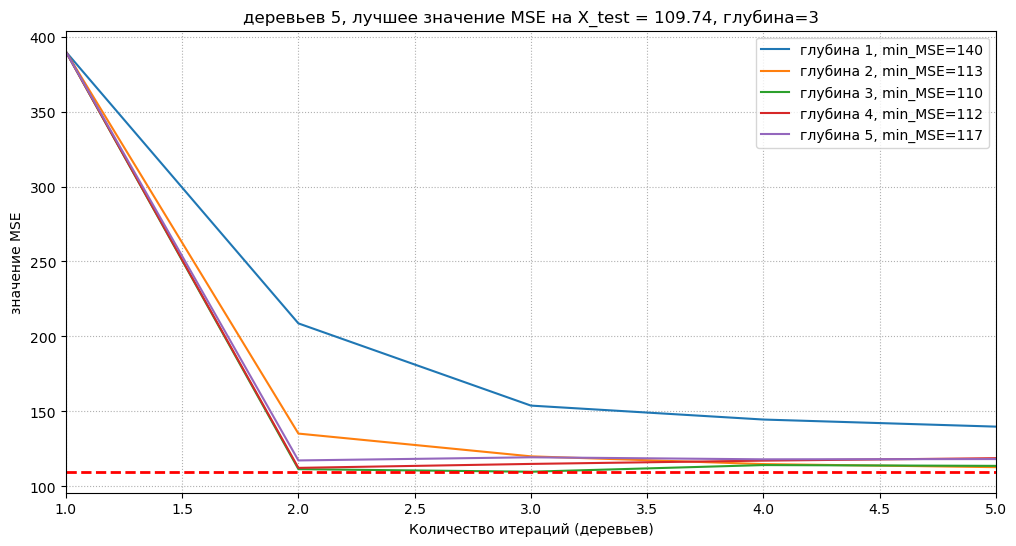

In [10]:
# попробуем 5 деревьев со скоростью 2
get_error_plot(X_train, y_train, eta=1, n_trees=5)

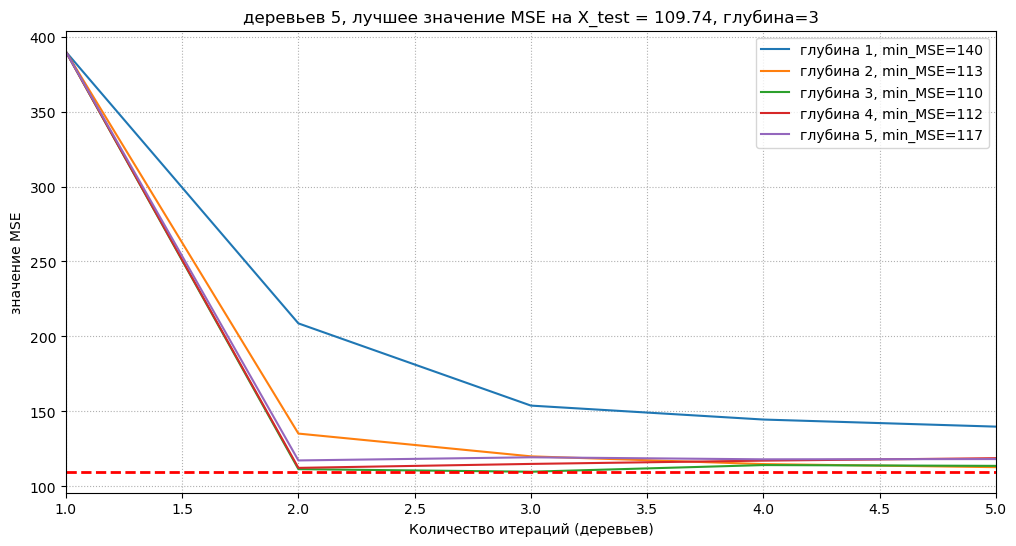

In [11]:
# или вот 5 деревьев со скоростью 1
get_error_plot(X_train, y_train, eta=1, n_trees=5)

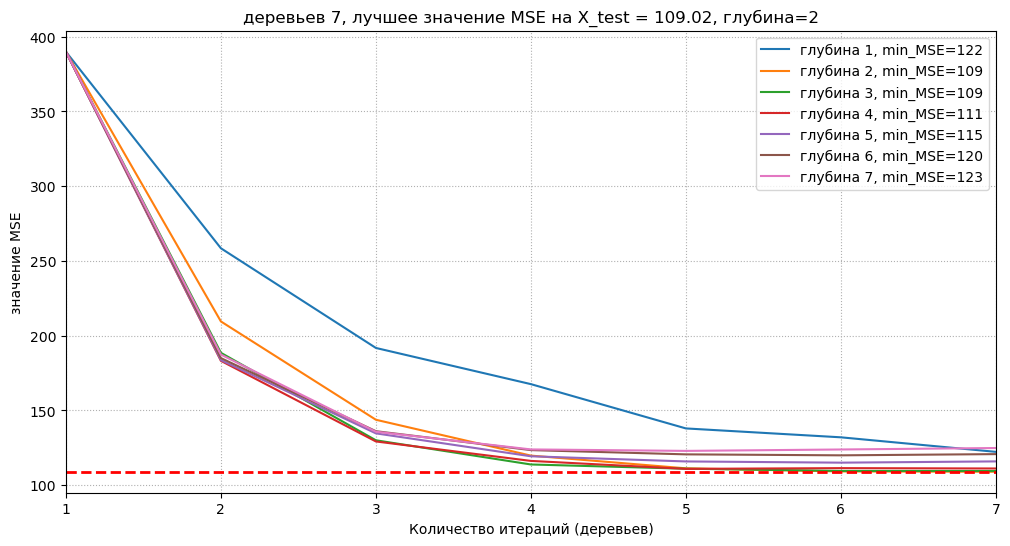

In [12]:
# 7 деревьев, а скорость 0.5
get_error_plot(X_train, y_train, eta=0.5, n_trees=7)

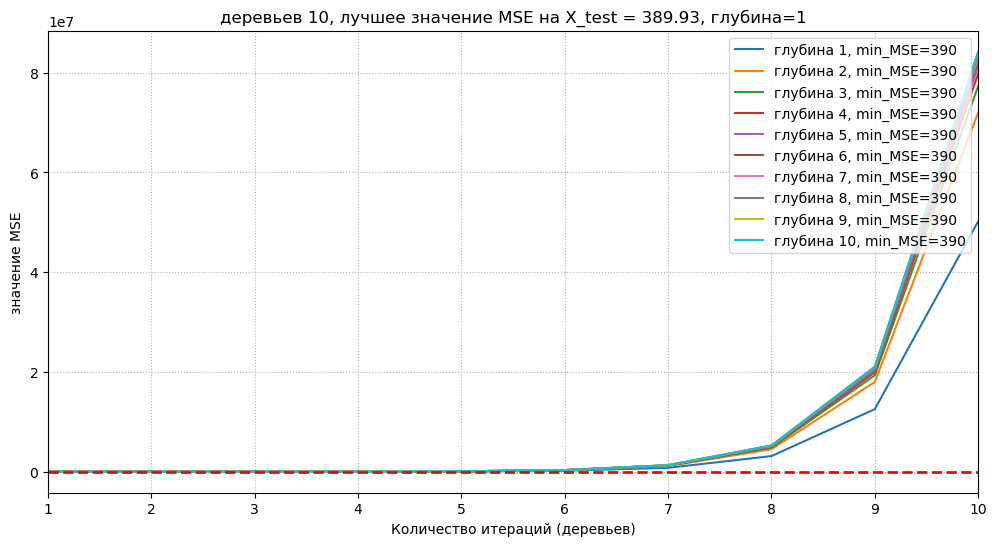

In [13]:
# попробуем 10 деревьев и скорость обучения 3 - улетели, переобучились
get_error_plot(X_test, y_test, eta=3, n_trees=10)

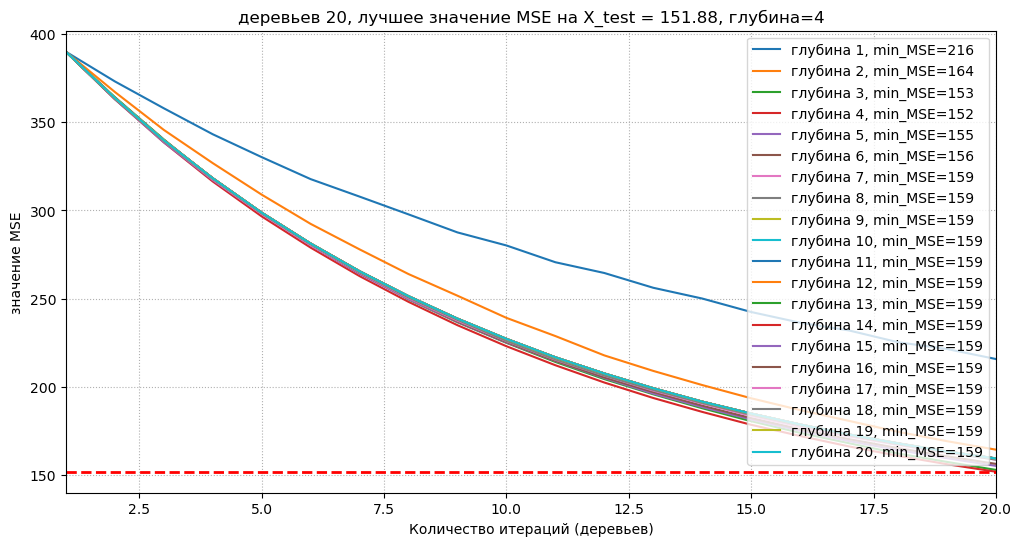

In [14]:
# теперь 20 деревьев и скорость обучения 0.05
get_error_plot(X_train, y_train, eta=0.05, n_trees=20)

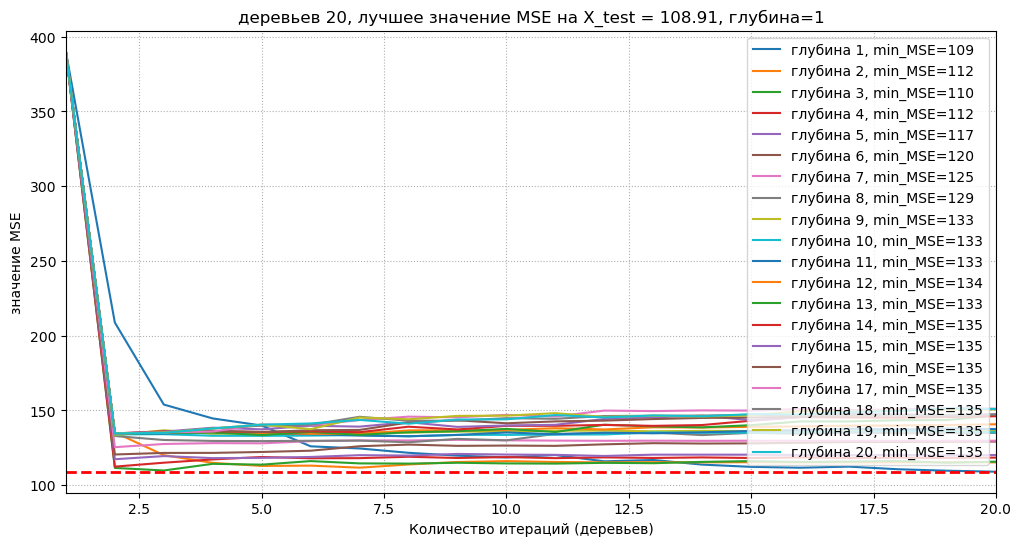

In [15]:
# теперь 20 деревьев и скорость обучения 1
get_error_plot(X_train, y_train, eta=1, n_trees=20)

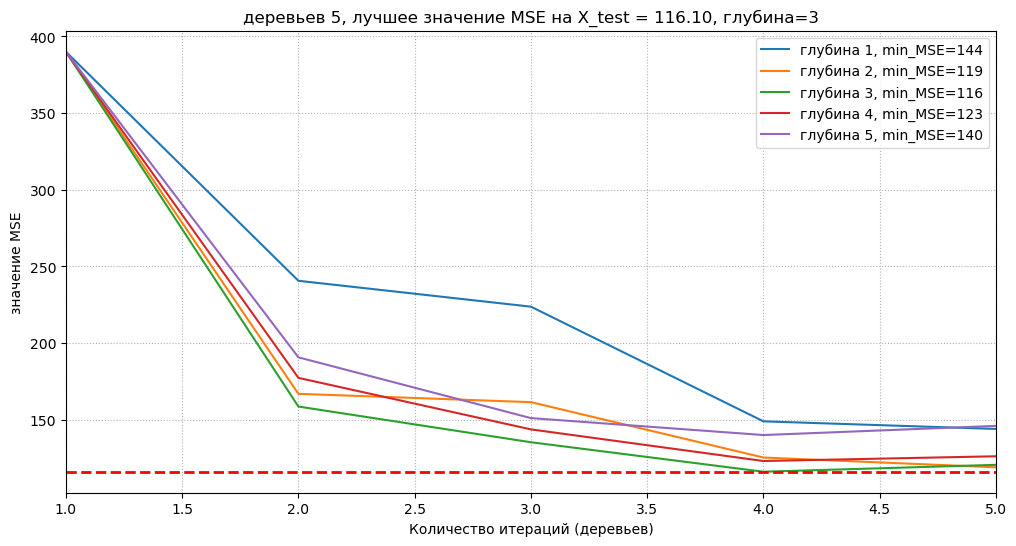

In [16]:
#и финальное - 3 деревьев с глубиной 3 и скоростью 0.05
get_error_plot(X_train, y_train, eta=1.5, n_trees=5)

**Вывод**: 

градиентному бустингу, как правильно, не требуется много деревьев и минимальное значение MSE часто получается на алгоритме с небольшим количеством деревьев

Глубина деревьев так же имеет значение - глубокие деревья могут приводить к быстрому переобучению

Скорость обучения обратно пропорциональна количеству деревьев, чем она ниже, тем больше требуется деревьев для достижения минимума MSE

При этом большая скорость обучения может заставить алгоритм "улететь" с первой же итерацией, поэтому для достижения хороших результатов нужно внимательно подбирать параметры 

попробуем подобрать оптимальные параметры для отложенной выборки

In [17]:
def find_best_mse(X, y, n_trees=10, max_depth=10, eta=1.35):
    '''
    находит лучшее значение R2
    n_trees - Число деревьев в ансамбле
    max_depth - Максимальная глубина деревьев
    eta - Шаг
    
    '''
    best_r2 = 0
    best_n_trees, best_max_depth, best_eta = None, None, None
    count = 1
    
    for learning_rate in range(15):
        eta *= 0.75
        #print(f'{count}) eta = {eta:.4f}')
        
        for tree in range(1, n_trees+1):

            for depth in range(1, max_depth+1):
                coefs = [1] * tree       # для простоты примем коэффициенты равными 1

                gb = GradientBoosting(coefs, tree, depth, eta)
                gb.fit(X, y)
                r2 = r_2(gb.predict(X_train), y_train)

                if best_r2 < r2:
                    best_r2 = r2
                    best_n_trees = tree
                    best_max_depth = depth
                    best_eta = eta 
        count += 1
    print(f'best_n_trees = {tree}\nbest_max_depth = {best_max_depth}\nr2 = {best_r2:.4f}\nbest_eta = {best_eta:.4f}')
    
    return best_n_trees, best_max_depth, best_eta


In [18]:
best_n_trees, best_max_depth, best_eta = find_best_mse(X_test, y_test, n_trees=5, max_depth=5)

best_n_trees = 5
best_max_depth = 3
r2 = 0.6890
best_eta = 0.4271


In [19]:
coefs = [1] * best_n_trees
gb = GradientBoosting(coefs, best_n_trees, best_max_depth, best_eta)
gb.fit(X_train, y_train)

print(f'R2 на train = {r_2(gb.predict(X_train), y_train):.4f}')
print(f'R2 на test = {r_2(gb.predict(X_test), y_test):.4f}')

R2 на train = 0.7436
R2 на test = 0.7139
